# **1. IMPORTS AND REQUIREMENTS**

## 1.1 Requirements

In [ ]:
!pip install contractions
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible

## 1.2 Imports

In [ ]:
# File management
import shutil
import os
# ---

# Text pre-processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS

import string
import re

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.corpus   import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem     import WordNetLemmatizer

import contractions

import tensorflow as tf
from gensim.models import Word2Vec  # genshin

from collections import Counter     # for LSTM
# ---

# Dataset management
import kagglehub

import numpy  as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
# ---

# Machine learning
from sklearn.linear_model   import LogisticRegression
from sklearn.ensemble       import RandomForestClassifier
from sklearn.metrics        import accuracy_score
from sklearn.pipeline       import Pipeline
from sklearn.preprocessing  import LabelEncoder, Normalizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, TextVectorization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import RMSprop

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree     import DecisionTreeClassifier

import torch
import torch.nn             as nn
import torch.nn.functional  as F
import torch.optim          as optim

from datasets     import Dataset
from transformers import DistilBertModel, DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding


from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from imblearn.over_sampling import RandomOverSampler
# ---

# Plotting
import matplotlib.pyplot  as plt
import seaborn            as sns

from sklearn.metrics        import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay

from collections import defaultdict
# ---

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## 1.3 Evaluation metrics

We also define a function for evaluation purposes in order to plot the roc and auroc graphics for the different prediction models:

A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the performance of a binary classifier model (it can be used for multi class classification as well) at varying threshold values.

The ROC curve is the plot of the true positive rate (TPR) against the false positive rate (FPR) at each threshold setting.

In [ ]:
def roc_auroc(y, pred, title: str):
  fpr, tpr, thresholds = roc_curve(y, pred)
  roc_auc = auc(fpr, tpr)

  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve - ' + title)
  plt.legend(loc="lower right")
  plt.show()

# **2. DATASETS**

In [ ]:
proj_path = os.getcwd()

## 2.1 Dataset 1 - aadyasingh55/fake-news-classification


> The Fake News Classification Dataset is an English-language dataset containing just over 45,000 unique news articles. These articles are classified as true (1) or false (0), making it a valuable resource for researchers and practitioners in the field of fake news identification using Transformers models. This is the first version of the dataset aimed at studying fake news detection.

[Link to the dataset](https://www.kaggle.com/datasets/aadyasingh55/fake-news-classification)

In [ ]:
dataset1_path = os.path.join(proj_path, 'd1')
os.makedirs(dataset1_path, exist_ok=True)
dataset1_path = os.path.join(dataset1_path, '1')


if not os.path.exists(dataset1_path):
    path = kagglehub.dataset_download("aadyasingh55/fake-news-classification")
    shutil.move(path, dataset1_path)

try:
    ds1_train_df = pd.read_csv(os.path.join(dataset1_path, 'train (2).csv'), on_bad_lines='skip',sep=';')
    print("Train dataset loaded successfully.")
except Exception as e:
    print(f"Error loading train dataset: {e}")

try:
    ds1_test_df = pd.read_csv(os.path.join(dataset1_path, 'test (1).csv'), on_bad_lines='skip',sep=';')
    print("Test dataset loaded successfully.")
except Exception as e:
    print(f"Error loading train dataset: {e}")

try:
    ds1_eval_df = pd.read_csv(os.path.join(dataset1_path, 'evaluation.csv'), on_bad_lines='skip',sep=';')
    print("Evaluation dataset loaded successfully.")
except Exception as e:
    print(f"Error loading evaluation dataset: {e}")

ds1_train_df = ds1_train_df.drop(columns=['Unnamed: 0'])
ds1_test_df = ds1_test_df.drop(columns=['Unnamed: 0'])
ds1_eval_df = ds1_eval_df.drop(columns=['Unnamed: 0'])

100%|██████████| 39.0M/39.0M [00:00<00:00, 101MB/s]

Extracting files...


Train dataset loaded successfully.
Test dataset loaded successfully.
Evaluation dataset loaded successfully.


In [ ]:
# For LSTM

ds1_df = pd.concat([ds1_train_df, ds1_test_df, ds1_eval_df])

In [ ]:
ds1_X_train = ds1_train_df['text']
ds1_y_train = ds1_train_df['label']

ds1_X_test = ds1_test_df['text']
ds1_y_test = ds1_test_df['label']

ds1_X_eval = ds1_eval_df['text']
ds1_y_eval = ds1_eval_df['label']

## 2.2 Dataset 2 - stevenpeutz/misinformation-fake-news-text-dataset-79k

> A dataset containing 79k articles of misinformation, fake news and propaganda.

[Link to the dataset](https://www.kaggle.com/datasets/stevenpeutz/misinformation-fake-news-text-dataset-79k)

In [ ]:
dataset2_path = os.path.join(proj_path, 'd2')
dataset2_path = os.path.join(dataset2_path, '2')

if not os.path.exists(dataset2_path):
  path2 = kagglehub.dataset_download("stevenpeutz/misinformation-fake-news-text-dataset-79k")
  shutil.move(path2, dataset2_path)

try:
    ds2_fake_df = pd.read_csv(os.path.join(dataset2_path, 'DataSet_Misinfo_FAKE.csv'))
    print("Fake dataset loaded successfully.")
except Exception as e:
    print(f"Error loading fake dataset: {e}")

try:
    ds2_true_df = pd.read_csv(os.path.join(dataset2_path, 'DataSet_Misinfo_TRUE.csv'))
    print("True dataset loaded successfully.")
except Exception as e:
    print(f"Error loading true dataset: {e}")

ds2_fake_df = ds2_fake_df.drop(columns=['Unnamed: 0'])
ds2_true_df = ds2_true_df.drop(columns=['Unnamed: 0'])

100%|██████████| 84.6M/84.6M [00:01<00:00, 82.7MB/s]

Extracting files...


Fake dataset loaded successfully.
True dataset loaded successfully.


In [ ]:
ds2_fake_df['label'] = 0
ds2_true_df['label'] = 1

ds2_fake_df = ds2_fake_df.dropna()
ds2_true_df = ds2_true_df.dropna()

ds2_df = pd.concat([ds2_fake_df, ds2_true_df])

In [ ]:
ds2_X_train, ds2_X_test, ds2_y_train, ds2_y_test  = train_test_split(ds2_df['text'], ds2_df['label'], train_size=0.7, test_size=0.3)
ds2_X_test, ds2_X_eval, ds2_y_test, ds2_y_eval    = train_test_split(ds2_X_test, ds2_y_test, train_size=0.5, test_size=0.5)

# **3. TEXT PRE-PROCESSING**

## 3.1 Text cleaning

The function *`clean_text`*, is designed to prepare the text data by removing unnecessary elements and it is used used in :
* *Logistic regression*
* *LSTM*
* *ADABoost*
* *Random Forest*

In [ ]:
def clean_text(text: str) -> str:
    """
    Function to remove stopwords, punctuation and apply stemming on text.

    Args:
        text (str): text to clean.

    Returns:
        cleaned_text (str): cleaned text.
    """

    stop_words = set(ENGLISH_STOP_WORDS)
    stop_words.add('reuters')

    # 1 - lower casing
    text = text.lower()

    # 2 - removing special characters, non-alphanumerics
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'\S+@\S+', '', text)                  # Remove email addresses
    text = re.sub(r'[^A-Za-z\s]', '', text)              # Remove non-alphanumeric characters
    text = re.sub(r'[^\x00-\x7f]', '', text)             # Remove non-ASCII characters
    text = re.sub(r"\s\s+", " ", text)                   # remove multiple spaces

    contractions.fix(text)
    words = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()

    remaining = [
        lemmatizer.lemmatize(word)
        for word in words
        if word.strip() not in stop_words and word not in string.punctuation]

    remaining = [word for word in remaining if len(word) > 3]

    # 3 - removing extra spaces
    cleaned_text = ' '.join(remaining)

    return cleaned_text

In [ ]:
ds1_cleanX_train = ds1_X_train.apply(clean_text)
ds1_cleanX_test = ds1_X_test.apply(clean_text)
ds1_cleanX_eval = ds1_X_eval.apply(clean_text)

In [ ]:
ds1_X = ds1_df['text']
ds1_y = ds1_df['label']
ds1_X = ds1_X.apply(clean_text)

In [ ]:
ds2_cleanX_train = ds2_X_train.apply(clean_text)
ds2_cleanX_test = ds2_X_test.apply(clean_text)
ds2_cleanX_eval = ds2_X_eval.apply(clean_text)

In [ ]:
ds2_X = ds2_df['text']
ds2_y = ds2_df['label']
ds2_X = ds2_X.apply(clean_text)

In [ ]:
ds2_cleanX_train, ds2_cleanX_test, ds2_y_train, ds2_y_test  = train_test_split(ds2_X, ds2_y, train_size=0.7, test_size=0.3)
ds2_cleanX_test, ds2_cleanX_eval, ds2_y_test, ds2_y_eval    = train_test_split(ds2_cleanX_test, ds2_y_test, train_size=0.5, test_size=0.5)

## 3.2 Vectorization and normalization

Since text data is unstructured it needs to be transformed into numerical representations that models can process.  This transformation process is known as *vectorization*.

Furthermore, *normalization* is important to ensure that the feature values are scaled appropriately. It prevents features with larger numerical ranges from dominating the learning process.


In [ ]:
def vectorize(X_test: pd.Series, X_train: pd.Series = None, vectorizer: CountVectorizer = None) -> tuple[pd.Series | None, pd.Series, CountVectorizer]:
  """ Apply the vectorization using `CountVectorizer``

  Args:
    X_test      (ps.Series): Test data.
    X_train     (pd.Series): Train data. Default to None. If present it gets transformed with `fit_transform()`.
    vectorizer  (CountVectorizer): Vectorizer to use. If not specified it makes a new one. Default to None.

  Returns:
    tuple[pd.Series, pd.Series, CountVectorizer]: Transformed `X_train`and `X_test`, vectorizer used.
  """

  if vectorizer is None:
    vectorizer = CountVectorizer(ngram_range=(1, 1))

  if X_train is not None:
    X_train = vectorizer.fit_transform(X_train)

  X_test = vectorizer.transform(X_test)

  return X_train, X_test, vectorizer

In [ ]:
def normalize(X_test: pd.Series, X_train: pd.Series = None, normalizer: Normalizer = None) -> tuple[pd.Series | None, pd.Series, Normalizer]:
  """ Apply the vectorization using `CountVectorizer``

  Args:
    X_test      (ps.Series): Test data.
    X_train     (pd.Series): Train data. Default to None. If present it gets transformed with `fit_transform()`.
    normalizer  (Normalizer): Normalizer to use. If not specified it makes a new one. Default to None.

  Returns:
    tuple[pd.Series, pd.Series, Normalizer]: Transformed `X_train`and `X_test`, normalizer used.
  """

  if normalizer is None:
    normalizer = Normalizer()

  if not X_train is None:
    X_train = normalizer.fit_transform(X_train)

  X_test = normalizer.transform(X_test)

  return X_train, X_test, normalizer

We apply the same vectorizer and normalizer on all the datasets so that we can do cross-dataset testing of the models.

*Bag of Words* (BoW) is one of the simplest and most commonly used text vectorization techniques. A vocabulary is built from all the unique tokens (words or n-grams) across the dataset.
Using this vocabulary, a sparse matrix is generated, where each row corresponds to a vector representation of a text, and the columns represent the vocabulary terms. The value in each cell indicates the frequency of the corresponding vocabulary word in the text.

In [ ]:
# Learns the vocabulary on the train split of Dataset 1 and applies it on the test split of the other datasets.

ds1_X_train, ds1_X_test, vectorizer = vectorize(X_train=ds1_cleanX_train, X_test=ds1_cleanX_test)
ds1_X_train, ds1_X_test, normalizer = normalize(X_train=ds1_X_train, X_test=ds1_X_test)

ds2_X_test_1 = vectorize(ds2_cleanX_test, vectorizer=vectorizer)[1]
ds2_X_test_1 = normalize(ds2_X_test_1, normalizer=normalizer)[1]

In [ ]:
# Learns the vocabulary on the train split of Dataset 2 and applies it on the test split of the other datasets.

ds2_X_train, ds2_X_test, vectorizer = vectorize(X_train=ds2_cleanX_train, X_test=ds2_cleanX_test)
ds2_X_train, ds2_X_test, normalizer = normalize(X_train=ds2_X_train, X_test=ds2_X_test)

ds1_X_test_2 = vectorize(ds1_cleanX_test, vectorizer=vectorizer)[1]
ds1_X_test_2 = normalize(ds1_X_test_2, normalizer=normalizer)[1]

We repreat the process similarly, considering 2-gram features instead of unigrams.

In [ ]:
ngram2 = CountVectorizer(ngram_range=(1, 2))

ds1_X_train_2gram, ds1_X_test_2gram, _          = vectorize(X_train=ds1_cleanX_train, X_test=ds1_cleanX_test, vectorizer=ngram2)
ds1_X_train_2gram, ds1_X_test_2gram, normalizer = normalize(X_train=ds1_X_train_2gram, X_test=ds1_X_test_2gram)

ds2_X_train_2gram, ds2_X_test_2gram, _          = vectorize(X_train=ds2_cleanX_train, X_test=ds2_cleanX_test, vectorizer=ngram2)
ds2_X_train_2gram, ds2_X_test_2gram, normalizer = normalize(X_train=ds2_X_train_2gram, X_test=ds2_X_test_2gram)

*Term Frequency-Inverse Document Frequency* (TF-IDF) not only counts the frequency of each word but also assigns a weight to them based on their frequency in the document and in the entire corpus.
As a result, the words that are more significant or informative in the document get assigned higher weights.



In [ ]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

ds1_X_train_tfidf, ds1_X_test_tfidf, _          = vectorize(X_train=ds1_cleanX_train, X_test=ds1_cleanX_test, vectorizer=tfidf)
ds1_X_train_tfidf, ds1_X_test_tfidf, normalizer = normalize(X_train=ds1_X_train_tfidf, X_test=ds1_X_test_tfidf)

ds2_X_train_tfidf, ds2_X_test_tfidf, _          = vectorize(X_train=ds2_cleanX_train, X_test=ds2_cleanX_test, vectorizer=tfidf)
ds2_X_train_tfidf, ds2_X_test_tfidf, normalizer = normalize(X_train=ds2_X_train_tfidf, X_test=ds2_X_test_tfidf)

# **4. LOGISTIC REGRESSION**

## 4.1 Fitting and scores

In [ ]:
def applyLogistic(X_train: pd.Series, X_test: pd.Series, y_train: pd.Series, y_test: pd.Series, random_state: int = 42, max_iter: int = 1000) -> tuple[float, LogisticRegression]:
  """Calculate the accuracy of a Logistic Regression model.

  Args:
    X_train (pd.Series): Train data.
    X_test (pd.Series): Test data.
    y_train (pd.Series): Labels for the train data.
    y_test (pd.Series): Labels for the test data.
    random_state (int): Random state for the logistic regression model.
    max_iter (int): Max number of iteration for the logistic regression model.

  Returns:
    tuple[float, LogisticRegression]: Accuracy (score) of the model and the model.
  """
  model = LogisticRegression(random_state=random_state, max_iter=max_iter)
  model.fit(X_train, y_train)

  # Calculate the accuracy
  score = model.score(X_test, y_test)
  print(f"Accuracy: {score}")
  print(classification_report(y_test, model.predict(X_test)))
  return [score, model]

In [ ]:
ds1_score, lg_model1 = applyLogistic(ds1_X_train, ds1_X_test, ds1_y_train, ds1_y_test)

ds2_score, lg_model2 = applyLogistic(ds2_X_train, ds2_X_test, ds2_y_train, ds2_y_test)

Accuracy: 0.9581126031785142
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3753
           1       0.96      0.96      0.96      4364

    accuracy                           0.96      8117
   macro avg       0.96      0.96      0.96      8117
weighted avg       0.96      0.96      0.96      8117

Accuracy: 0.927638276213098
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      6553
           1       0.92      0.91      0.92      5235

    accuracy                           0.93     11788
   macro avg       0.93      0.93      0.93     11788
weighted avg       0.93      0.93      0.93     11788



In [ ]:
ds1_score_2 = lg_model1.score(ds2_X_test_1, ds2_y_test)
print(ds1_score_2)

0.8590939938920936


In [ ]:
ds2_score_1 = lg_model2.score(ds1_X_test_2, ds1_y_test)
print(ds2_score_1)

0.9556486386596033


## 4.2 Plotting the results

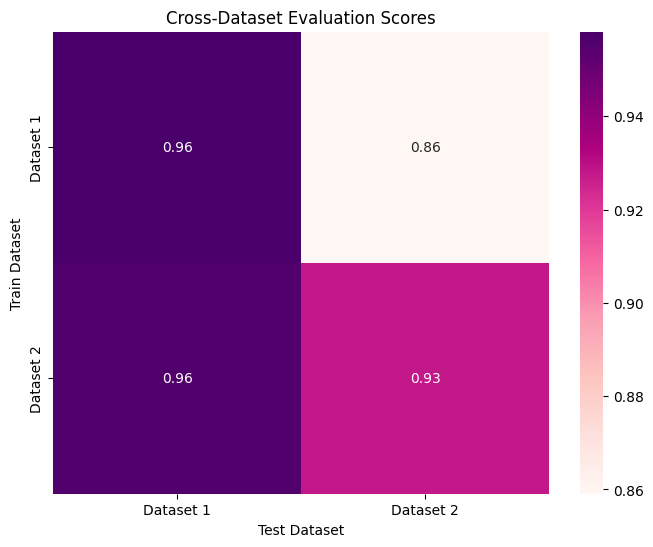

In [ ]:
datasets = ['Dataset 1', 'Dataset 2']
scores = [
    [ds1_score, ds1_score_2],  # Train on Dataset 1
    [ds2_score_1, ds2_score],  # Train on Dataset 2
]

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(scores, annot=True, fmt=".2f", cmap="RdPu", xticklabels=datasets, yticklabels=datasets)
plt.xlabel('Test Dataset')
plt.ylabel('Train Dataset')
plt.title('Cross-Dataset Evaluation Scores')
plt.show()


Apply logistic regression with 2-gram features

In [ ]:
ds1_score_2gram, lg_model1_2gram = applyLogistic(ds1_X_train_2gram, ds1_X_test_2gram, ds1_y_train, ds1_y_test)
ds2_score_2gram, lg_model2_2gram = applyLogistic(ds2_X_train_2gram, ds2_X_test_2gram, ds2_y_train, ds2_y_test)

Accuracy: 0.9582358014044597
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3753
           1       0.96      0.97      0.96      4364

    accuracy                           0.96      8117
   macro avg       0.96      0.96      0.96      8117
weighted avg       0.96      0.96      0.96      8117

Accuracy: 0.9324737020699015
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      6553
           1       0.92      0.92      0.92      5235

    accuracy                           0.93     11788
   macro avg       0.93      0.93      0.93     11788
weighted avg       0.93      0.93      0.93     11788



Apply logistic regression with TF-IDF features

In [ ]:
ds1_score_tfidf, lg_model1_tfidf = applyLogistic(ds1_X_train_tfidf, ds1_X_test_tfidf, ds1_y_train, ds1_y_test)
ds2_score_tfidf, lg_model2_tfidf = applyLogistic(ds2_X_train_tfidf, ds2_X_test_tfidf, ds2_y_train, ds2_y_test)

Accuracy: 0.9648885056055193
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3753
           1       0.97      0.97      0.97      4364

    accuracy                           0.96      8117
   macro avg       0.96      0.96      0.96      8117
weighted avg       0.96      0.96      0.96      8117

Accuracy: 0.930013573125212
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      6553
           1       0.93      0.91      0.92      5235

    accuracy                           0.93     11788
   macro avg       0.93      0.93      0.93     11788
weighted avg       0.93      0.93      0.93     11788



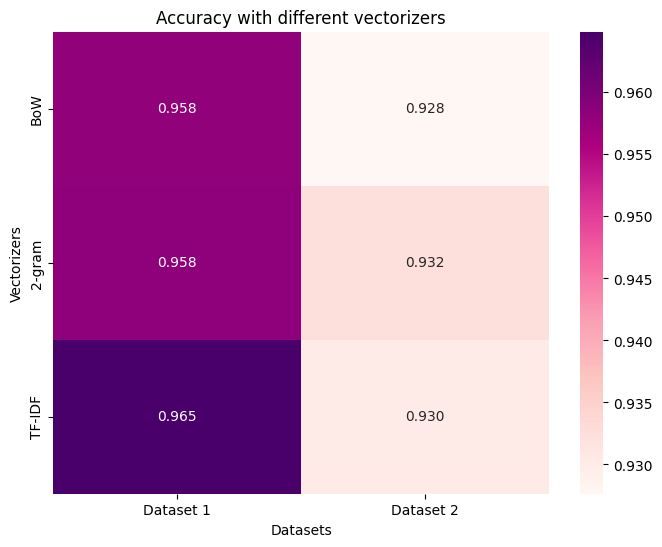

In [ ]:
datasets = ['Dataset 1', 'Dataset 2']
vectorizers = ['BoW', '2-gram', 'TF-IDF']
scores = [
    [ds1_score, ds2_score],  # BoW
    [ds1_score_2gram, ds2_score_2gram],  # 2gram
    [ds1_score_tfidf, ds2_score_tfidf],  # Tfidf
]

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(scores, annot=True, fmt=".3f", cmap="RdPu", xticklabels=datasets, yticklabels=vectorizers)
plt.xlabel('Datasets')
plt.ylabel('Vectorizers')
plt.title('Accuracy with different vectorizers')
plt.show()

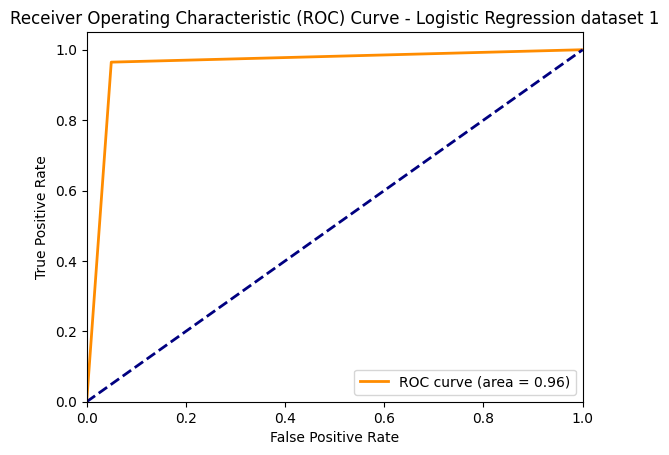

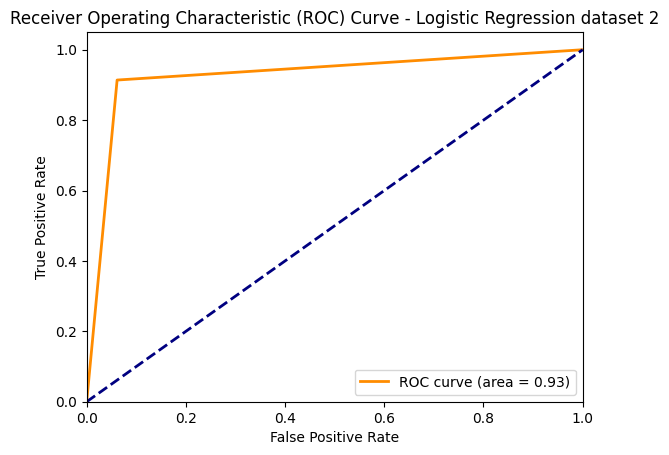

In [ ]:
predict1 = lg_model1.predict(ds1_X_test)
predict2 = lg_model2.predict(ds2_X_test)
roc_auroc(ds1_y_test, predict1, "Logistic Regression dataset 1")
roc_auroc(ds2_y_test, predict2, "Logistic Regression dataset 2")

# **5. CNN**

## 5.1 Text pre-processing for CNN



We need to convert the text data into numerical format to feed the CNN by using a text vectorizer, we adapt the vectorization according to the training set, so that it can be used to transform the text into sequences of integers, and we do this transformation for all of the datasets.

We start by building the model on the second dataset but then we will repeat the process also for the first dataset.

In [ ]:
ds2_X_trainCNN, ds2_X_testCNN, ds2_y_trainCNN, ds2_y_testCNN  = train_test_split(ds2_df['text'], ds2_df['label'], train_size=0.7, test_size=0.3)
ds2_X_testCNN, ds2_X_evalCNN, ds2_y_testCNN, ds2_y_evalCNN    = train_test_split(ds2_X_testCNN, ds2_y_testCNN, train_size=0.5, test_size=0.5)

ds1_X_trainCNN, ds1_X_testCNN, ds1_y_trainCNN, ds1_y_testCNN  = train_test_split(ds1_df['text'], ds1_df['label'], train_size=0.7, test_size=0.3)
ds1_X_testCNN, ds1_X_evalCNN, ds1_y_testCNN, ds1_y_evalCNN    = train_test_split(ds1_X_testCNN, ds1_y_testCNN, train_size=0.5, test_size=0.5)

In [ ]:
ds2_max_length = round(np.mean([len(i.split()) for i in ds2_X_train]))
vocabulary_size = 30000

text_vectorizer = TextVectorization(max_tokens=vocabulary_size,
                                    output_mode="int",
                                    output_sequence_length=ds2_max_length)

text_vectorizer.adapt(ds2_X_train)

ds2_test_padded   = text_vectorizer(ds2_X_testCNN)
ds2_train_padded  = text_vectorizer(ds2_X_trainCNN)
ds2_eval_padded   = text_vectorizer(ds2_X_evalCNN)

## 5.2 CNN Model

For the CNN we used the following hyperparameters:
* *Epochs:* 50
* *Batch Size:* 32
* *Loss Function:* binary cross entropy
* *Optimizer:* rmsprop
* *Dropout:* 0.5
* *Regulizer:* l1_l2
* *Learning Rate:* 0.0001

The model summary provides information about the number of parameters and the output shape of each layer.

In [ ]:
def CNNmodel (vocabulary_size:int, X_train:tf.Tensor, y_train:pd.Series, X_eval:tf.Tensor, y_eval:pd.Series):
  model = Sequential()

  model.add(Embedding(input_dim=vocabulary_size, output_dim=128)) # 128: dimension of embedding for each word

  model.add(Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))  # Fully connected layer
  model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

  model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'])

  training_history = model.fit(X_train, y_train,
                      epochs=50,
                      batch_size=32,
                      validation_data=(X_eval, y_eval))

  model.summary()
  return model , training_history

In [ ]:
model, training_history = CNNmodel(vocabulary_size, ds2_train_padded, ds2_y_trainCNN, ds2_eval_padded, ds2_y_evalCNN)

Epoch 1/50
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 52s 26ms/step - accuracy: 0.6626 - loss: 7.2729 - val_accuracy: 0.9143 - val_loss: 0.4043
Epoch 2/50
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 72s 24ms/step - accuracy: 0.9147 - loss: 0.3353 - val_accuracy: 0.9398 - val_loss: 0.2974
Epoch 3/50
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.9363 - loss: 0.2545 - val_accuracy: 0.9348 - val_loss: 0.2987
Epoch 4/50
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 82s 24ms/step - accuracy: 0.9463 - loss: 0.2197 - val_accuracy: 0.9562 - val_loss: 0.2207
Epoch 5/50
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.9531 - loss: 0.1998 - val_accuracy: 0.9589 - val_loss: 0.1997
Epoch 6/50
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - accuracy: 0.9586 - loss: 0.1807 - val_accuracy: 0.9612 - val_loss: 0.1962
Epoch 7/50
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - accuracy: 0.9586 - loss: 0.1733 - val_accuracy: 0.9621 - val_loss: 0.2025
Epoch 8/50
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - accuracy: 0.9625 -

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 477, 128)            │       3,840,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 473, 64)             │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 473, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 236, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 15104)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 15104)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         966,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,695,620 (36.99 MB)

 Trainable params: 4,847,809 (18.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,847,811 (18.49 MB)

In [ ]:
loss, accuracy = model.evaluate(ds2_eval_padded, ds2_y_evalCNN)
print('accuracy ', accuracy)

369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9687 - loss: 0.1365
accuracy  0.9715836644172668


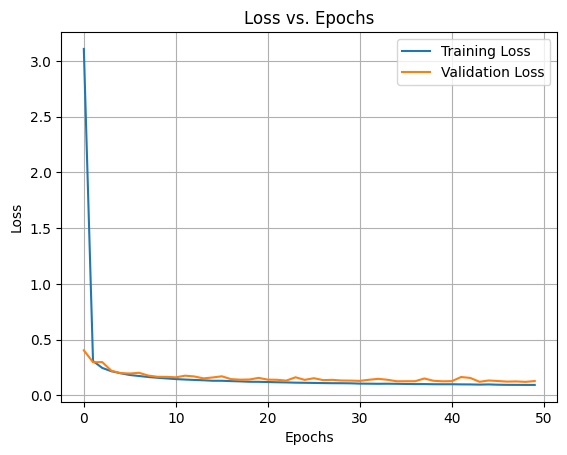

In [ ]:
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def apply_CNN(X:tf.Tensor, y:pd.Series, model):
  """Applying the CNN model to predict on the test dataset.

  Args:
    X (tf.Tensor): Test data.
    y (pd.Series): Labels of the test data.
    model (Sequential): CNN model.
  """

  predictions = model.predict(X)
  predicted_classes = (predictions > 0.5).astype(int)
  accuracy = accuracy_score(y, predicted_classes)
  print(f'Accuracy: {accuracy:.2f}')
  print("Classification Report:\n", classification_report(y, predicted_classes))
  print("Confusion Matrix: \n", confusion_matrix(y, predicted_classes), " \n")

  return predictions

In [ ]:
print("PREDICTIONS ON TEST SET OF DATASET 2 \n")
ds2_predictions = apply_CNN(ds2_test_padded, ds2_y_testCNN, model)

PREDICTIONS ON TEST SET OF DATASET 2 

369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      6610
           1       0.97      0.97      0.97      5178

    accuracy                           0.97     11788
   macro avg       0.97      0.97      0.97     11788
weighted avg       0.97      0.97      0.97     11788

Confusion Matrix: 
 [[6430  180]
 [ 158 5020]]  



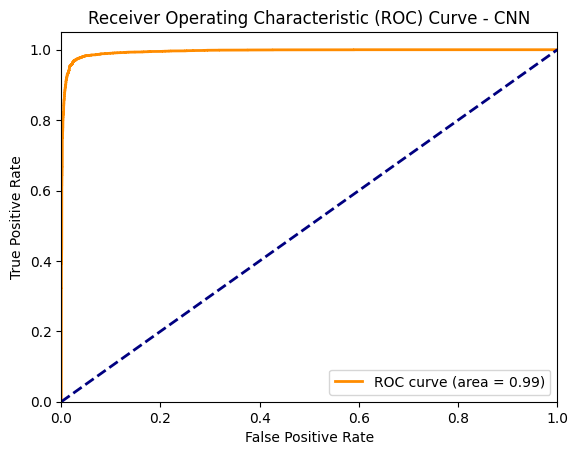

In [ ]:
roc_auroc(ds2_y_testCNN, ds2_predictions, "CNN")

In [ ]:
ds1_max_length = round(np.mean([len(i.split()) for i in ds1_X_trainCNN]))
vocabulary_size = 30000

text_vectorizer = TextVectorization(max_tokens=vocabulary_size,
                                    output_mode="int",
                                    output_sequence_length=ds1_max_length)

text_vectorizer.adapt(ds1_X_trainCNN)

ds1_test_padded   = text_vectorizer(ds1_X_testCNN)
ds1_train_padded  = text_vectorizer(ds1_X_trainCNN)
ds1_eval_padded   = text_vectorizer(ds1_X_evalCNN)

In [ ]:
ds1_model , training_history = CNNmodel(vocabulary_size, ds1_train_padded, ds1_y_trainCNN, ds1_eval_padded, ds1_y_evalCNN)

Epoch 1/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - accuracy: 0.6960 - loss: 10.2451 - val_accuracy: 0.9289 - val_loss: 0.4742
Epoch 2/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - accuracy: 0.9572 - loss: 0.3286 - val_accuracy: 0.9755 - val_loss: 0.2128
Epoch 3/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9748 - loss: 0.1815 - val_accuracy: 0.9768 - val_loss: 0.1756
Epoch 4/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.9745 - loss: 0.1544 - val_accuracy: 0.9785 - val_loss: 0.1482
Epoch 5/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9781 - loss: 0.1357 - val_accuracy: 0.9787 - val_loss: 0.1383
Epoch 6/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9805 - loss: 0.1235 - val_accuracy: 0.9800 - val_loss: 0.1296
Epoch 7/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9811 - loss: 0.1132 - val_accuracy: 0.9788 - val_loss: 0.1251
Epoch 8/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9797 - loss: 0.1114 -

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 408, 128)            │       3,840,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 404, 64)             │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 404, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 202, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12928)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12928)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         827,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,417,092 (35.92 MB)

 Trainable params: 4,708,545 (17.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,708,547 (17.96 MB)

In [ ]:
loss, accuracy = ds1_model.evaluate(ds1_eval_padded, ds1_y_evalCNN)
print('accuracy ', accuracy)

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9771 - loss: 0.1006
accuracy  0.9771719574928284


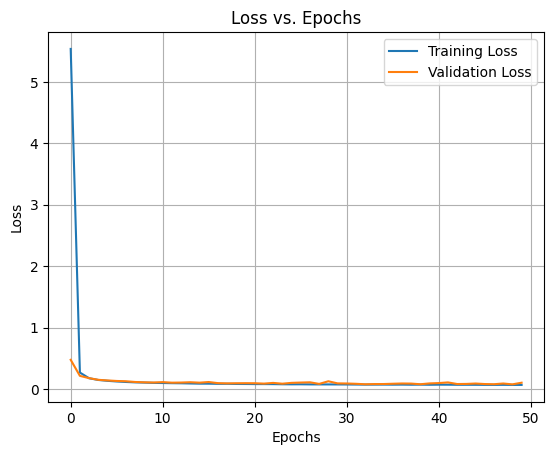

In [ ]:
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("PREDICTIONS ON TEST SET OF DATASET 1 \n")
ds1_predictions = apply_CNN(ds1_test_padded, ds1_y_testCNN, ds1_model)

PREDICTIONS ON TEST SET OF DATASET 1 

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97      2797
           1       0.97      0.99      0.98      3291

    accuracy                           0.98      6088
   macro avg       0.98      0.97      0.98      6088
weighted avg       0.98      0.98      0.98      6088

Confusion Matrix: 
 [[2681  116]
 [  34 3257]]  



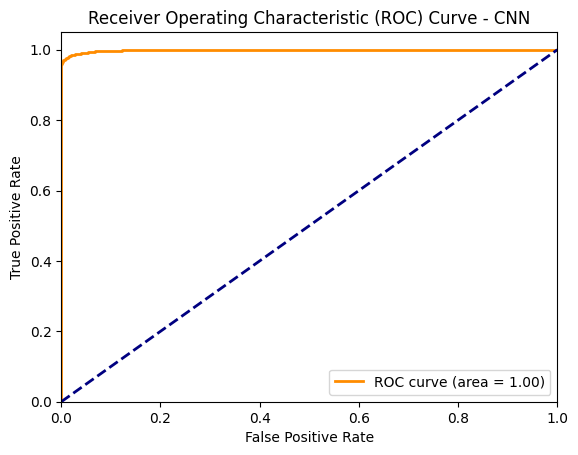

In [ ]:
roc_auroc(ds1_y_testCNN, ds1_predictions, "CNN")

# **6. ADABoost**

This script demonstrates how to define, train, and evaluate an AdaBoost classifier using a weak learner (`DecisionTreeClassifier`). The process includes fitting the model, making predictions, and evaluating performance using accuracy, classification metrics, and ROC-AUC.
We apply AdaBoost to the various datasets as well as to each vectorizer, aiming to experiment and determine which combination performs best.

In [ ]:
# Define weak learner for ADABoost
base_estimator = DecisionTreeClassifier(max_depth=1)
# Define ADABoost classifier
adaboost = AdaBoostClassifier(base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)

def train_and_evaluate_adaboost(X_train, y_train, X_test, y_test):
    # Fit the model
    adaboost.fit(X_train, y_train)
    # Predict and evaluate
    y_pred = adaboost.predict(X_test)
    y_prob = adaboost.predict_proba(X_test)[:, 1]

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    roc_auroc(y_test, y_prob, "AdaBoost")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9359369225083158
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3753
           1       0.94      0.95      0.94      4364

    accuracy                           0.94      8117
   macro avg       0.94      0.94      0.94      8117
weighted avg       0.94      0.94      0.94      8117



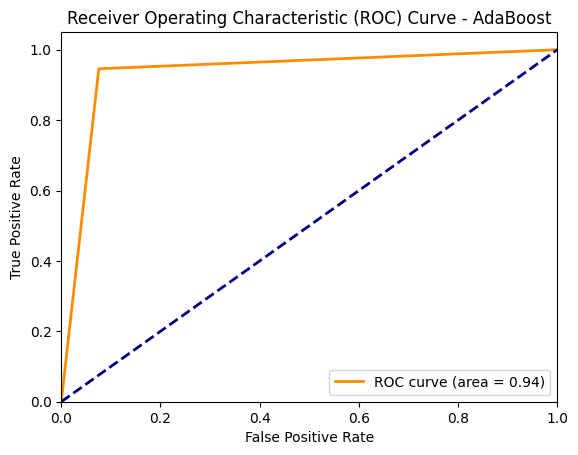

ROC-AUC: None


In [ ]:
# Apply the function to the different datasets
train_and_evaluate_adaboost(ds1_X_train, ds1_y_train, ds1_X_test, ds1_y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.8833559552086868
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      6553
           1       0.88      0.86      0.87      5235

    accuracy                           0.88     11788
   macro avg       0.88      0.88      0.88     11788
weighted avg       0.88      0.88      0.88     11788



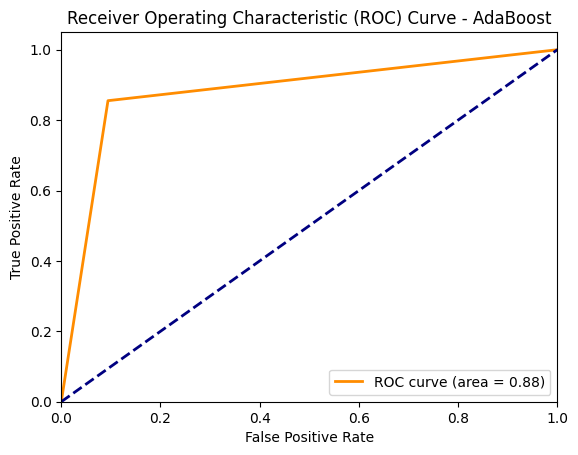

ROC-AUC: None


In [ ]:
train_and_evaluate_adaboost(ds2_X_train, ds2_y_train, ds2_X_test, ds2_y_test)

Accuracy: 0.9138844400640631
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      3753
           1       0.91      0.93      0.92      4364

    accuracy                           0.91      8117
   macro avg       0.91      0.91      0.91      8117
weighted avg       0.91      0.91      0.91      8117



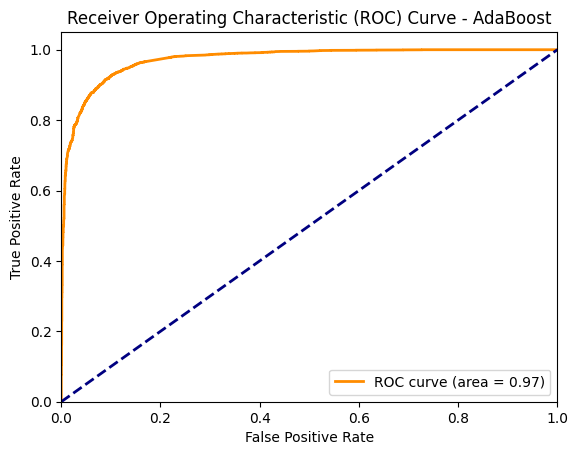

In [ ]:
# Applying ADABoost on 2gram vectorised data for dataset 1
train_and_evaluate_adaboost(ds1_X_train_2gram, ds1_y_train, ds1_X_test_2gram, ds1_y_test)

Accuracy: 0.8409399389209365
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      6542
           1       0.85      0.78      0.81      5246

    accuracy                           0.84     11788
   macro avg       0.84      0.84      0.84     11788
weighted avg       0.84      0.84      0.84     11788



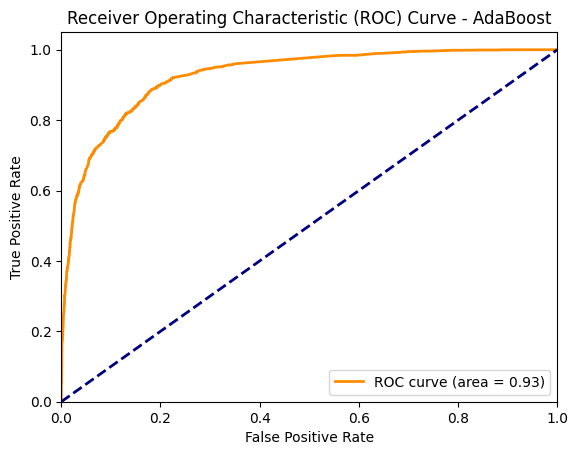

In [ ]:
# Applying ADABoost on 2gram vectorised data for dataset 2
train_and_evaluate_adaboost(ds2_X_train_2gram, ds2_y_train, ds2_X_test_2gram, ds2_y_test)

Accuracy: 0.9112972773192066
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      3753
           1       0.91      0.93      0.92      4364

    accuracy                           0.91      8117
   macro avg       0.91      0.91      0.91      8117
weighted avg       0.91      0.91      0.91      8117



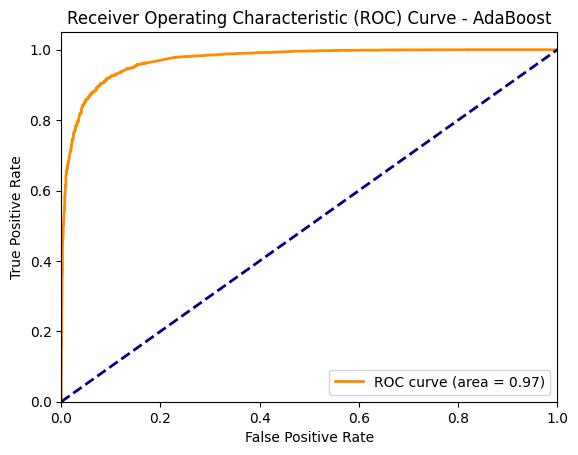

In [ ]:
# Applying ADABoost on tfidf vectorised data for dataset 1
train_and_evaluate_adaboost(ds1_X_train_tfidf, ds1_y_train, ds1_X_test_tfidf, ds1_y_test)

Accuracy: 0.8417034272141161
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      6542
           1       0.84      0.80      0.82      5246

    accuracy                           0.84     11788
   macro avg       0.84      0.84      0.84     11788
weighted avg       0.84      0.84      0.84     11788



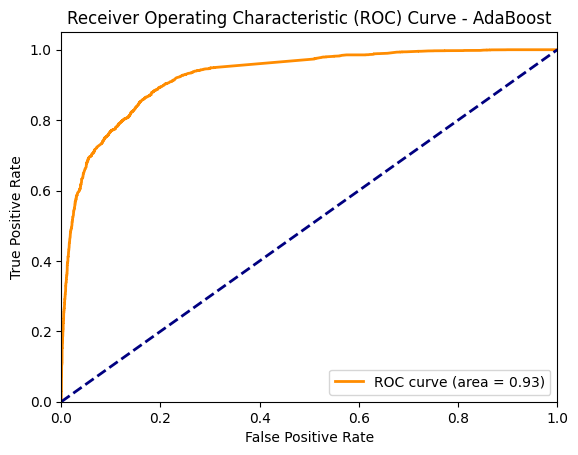

In [ ]:
# Applying ADABoost on tfidf vectorised data for dataset 2
train_and_evaluate_adaboost(ds2_X_train_tfidf, ds2_y_train, ds2_X_test_tfidf, ds2_y_test)

# **7. RANDOM FOREST**

Random Forest is  an ensemble
method that builds multiple decision trees during training, each of them constructed using a random subset of the
data set. Moreover the trees, for each candidate split in the learning process, select a random subset of the features.
For classification tasks, the final prediction is determined by the most frequent prediction across all trees.

In [ ]:
rf = RandomForestClassifier()

In [ ]:
grid = {
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

pipe_cv = GridSearchCV(
    estimator=rf,
    param_grid=grid,
    return_train_score=True
)
if pipe_cv is not None:
    pipe_cv.fit(ds1_X_train,ds1_y_train)

    print(f"Best score: {pipe_cv.best_score_}")
    for hp, val in pipe_cv.best_params_.items():
        print(f"{hp}: {val}")

In [ ]:
cv_res = pd.DataFrame(pipe_cv.cv_results_)
cv_res.columns = [col.split('__')[-1] for col in cv_res.columns]
print(cv_res)

In [ ]:
rf.fit(ds1_X_train, ds1_y_train)
ypred1 = rf.predict(ds1_X_test)
ypred1_2 = rf.predict(ds2_X_test_1)

RandomForestClassifier()

0.945669582358014
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      3753
           1       0.94      0.96      0.95      4364

    accuracy                           0.95      8117
   macro avg       0.95      0.94      0.95      8117
weighted avg       0.95      0.95      0.95      8117



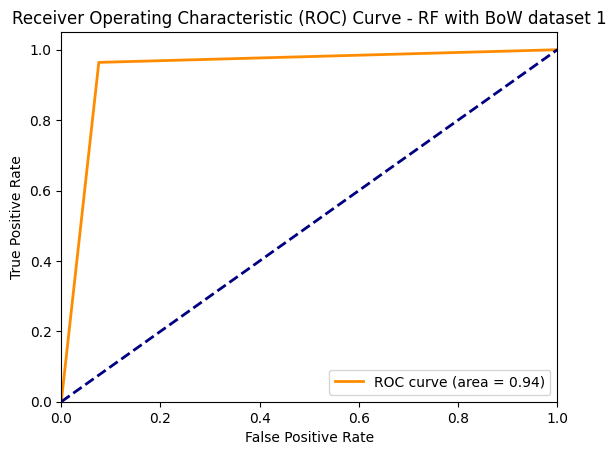

In [ ]:
rf1_score_Bow = accuracy_score(ds1_y_test, ypred1)
rf1_score_Bow_2 = accuracy_score(ds2_y_test, ypred1_2)
print(rf1_score_Bow)
print(classification_report(ds1_y_test, ypred1))
roc_auroc(ds1_y_test, ypred1, "RF with BoW dataset 1")

In [ ]:
rf.fit(ds2_X_train, ds2_y_train)
ypred2_1 = rf.predict(ds1_X_test_2)
ypred2 = rf.predict(ds2_X_test)

RandomForestClassifier()

0.9258568035290126
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      6553
           1       0.93      0.91      0.92      5235

    accuracy                           0.93     11788
   macro avg       0.93      0.92      0.92     11788
weighted avg       0.93      0.93      0.93     11788



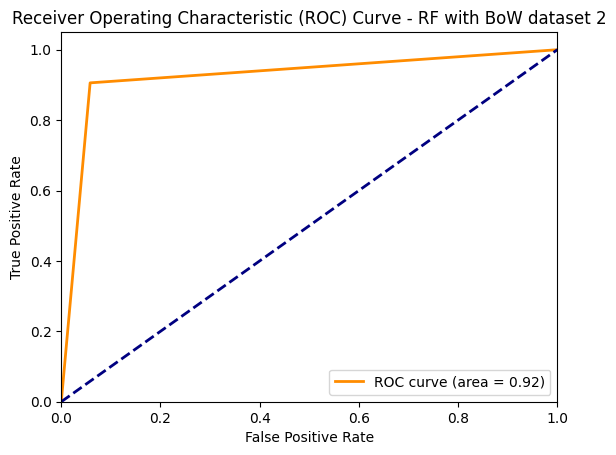

In [ ]:
rf2_score_Bow = accuracy_score(ds2_y_test, ypred2)
rf2_score_Bow_1 = accuracy_score(ds1_y_test, ypred2_1)
print(rf2_score_Bow)
print(classification_report(ds2_y_test, ypred2))
roc_auroc(ds2_y_test, ypred2, "RF with BoW dataset 2")

In [ ]:
rf.fit(ds1_X_train_2gram, ds1_y_train)
ypred1_2gram = rf.predict(ds1_X_test_2gram)

RandomForestClassifier()

0.9570038191450043
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3753
           1       0.95      0.97      0.96      4364

    accuracy                           0.96      8117
   macro avg       0.96      0.96      0.96      8117
weighted avg       0.96      0.96      0.96      8117



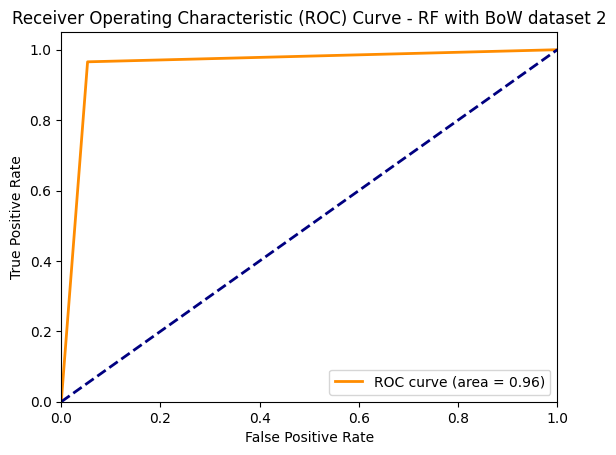

In [ ]:
rf1_score_2gram = accuracy_score(ds1_y_test, ypred1_2gram)
print(rf1_score_2gram)
print(classification_report(ds1_y_test, ypred1_2gram))
roc_auroc(ds1_y_test, ypred1_2gram, "RF with BoW dataset 2")

In [ ]:
rf.fit(ds2_X_train_2gram, ds2_y_train)
ypred2_2gram = rf.predict(ds2_X_test_2gram)

RandomForestClassifier()

0.9348489989820156
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6553
           1       0.94      0.91      0.93      5235

    accuracy                           0.93     11788
   macro avg       0.94      0.93      0.93     11788
weighted avg       0.93      0.93      0.93     11788



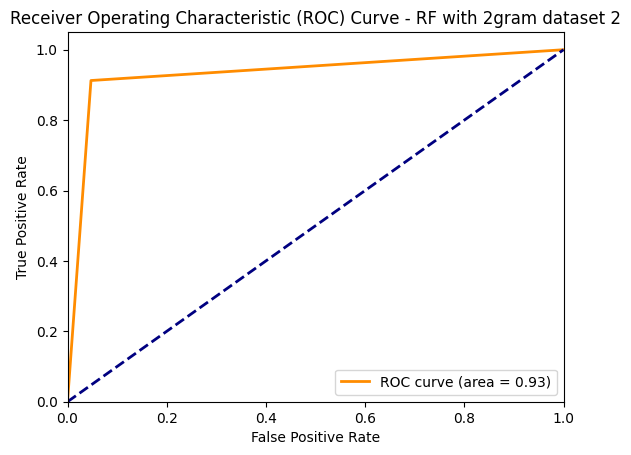

In [ ]:
rf2_score_2gram = accuracy_score(ds2_y_test, ypred2_2gram)
print(rf2_score_2gram)
print(classification_report(ds2_y_test, ypred2_2gram))
roc_auroc(ds2_y_test, ypred2_2gram, "RF with 2gram dataset 2")

In [ ]:
rf.fit(ds1_X_train_tfidf, ds1_y_train)
ypred1_tfidf = rf.predict(ds1_X_test_tfidf)

RandomForestClassifier()

0.9574966120487864
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3753
           1       0.96      0.96      0.96      4364

    accuracy                           0.96      8117
   macro avg       0.96      0.96      0.96      8117
weighted avg       0.96      0.96      0.96      8117



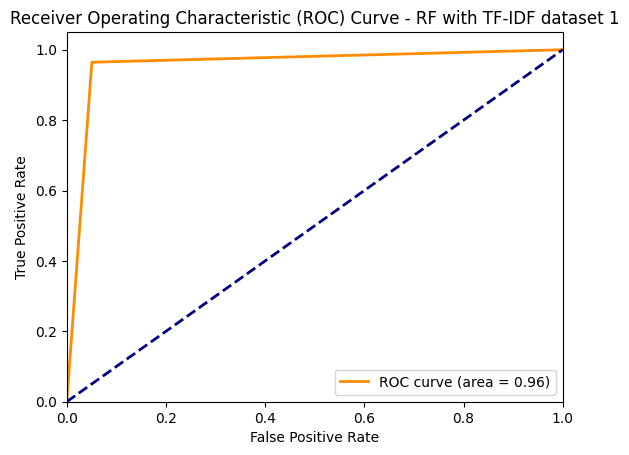

In [ ]:
rf1_score_tfidf = accuracy_score(ds1_y_test, ypred1_tfidf)
print(rf1_score_tfidf)
print(classification_report(ds1_y_test, ypred1_tfidf))
roc_auroc(ds1_y_test, ypred1_tfidf, "RF with TF-IDF dataset 1")

In [ ]:
rf.fit(ds2_X_train_tfidf, ds2_y_train)
ypred2_tfidf = rf.predict(ds2_X_test_tfidf)

RandomForestClassifier()

0.9376484560570071
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6553
           1       0.94      0.92      0.93      5235

    accuracy                           0.94     11788
   macro avg       0.94      0.94      0.94     11788
weighted avg       0.94      0.94      0.94     11788



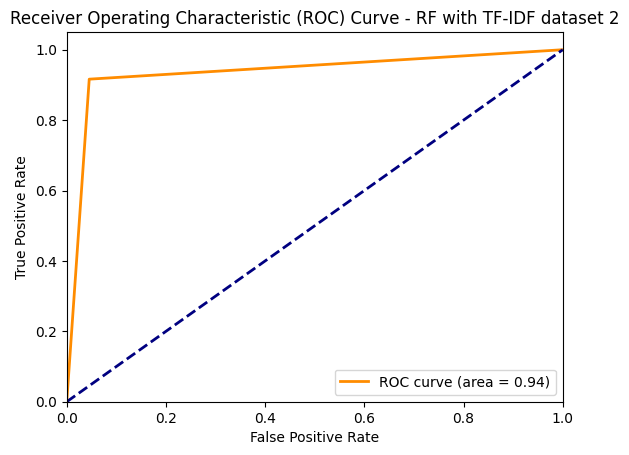

In [ ]:
rf2_score_tfidf = accuracy_score(ds2_y_test, ypred2_tfidf)
print(rf2_score_tfidf)
print(classification_report(ds2_y_test, ypred2_tfidf))
roc_auroc(ds2_y_test, ypred2_tfidf, "RF with TF-IDF dataset 2")

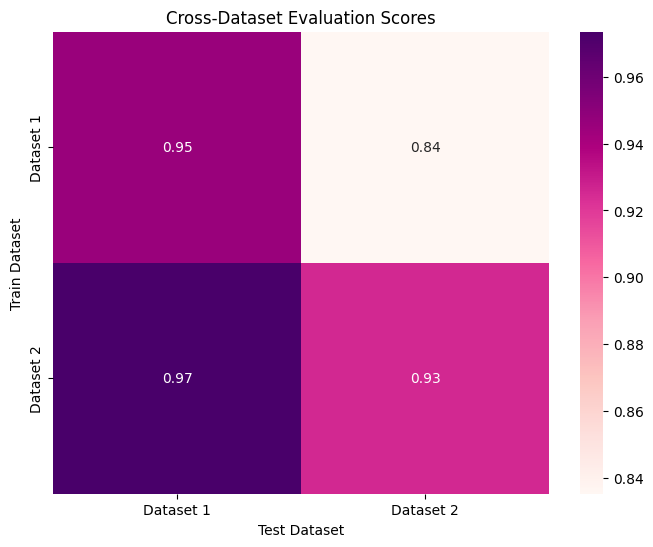

In [ ]:
datasets = ['Dataset 1', 'Dataset 2']
scores = [
    [rf1_score_Bow, rf1_score_Bow_2 ],  # Train on Dataset 1
    [rf2_score_Bow_1, rf2_score_Bow],  # Train on Dataset 2
]

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(scores, annot=True, fmt=".2f", cmap="RdPu", xticklabels=datasets, yticklabels=datasets)
plt.xlabel('Test Dataset')
plt.ylabel('Train Dataset')
plt.title('Cross-Dataset Evaluation Scores')
plt.show()

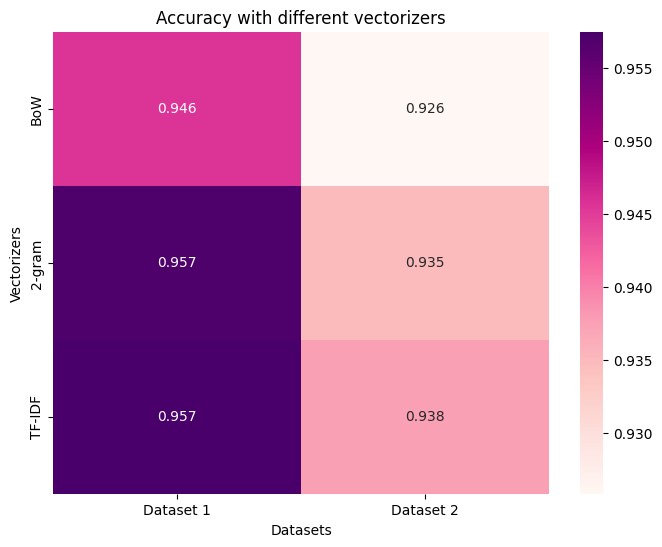

In [ ]:
datasets = ['Dataset 1', 'Dataset 2']
vectorizers = ['BoW', '2-gram', 'TF-IDF']
scores = [
    [rf1_score_Bow, rf2_score_Bow],  # BoW
    [rf1_score_2gram, rf2_score_2gram], #2gram
    [rf1_score_tfidf, rf2_score_tfidf], #tfidf
]

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(scores, annot=True, fmt=".3f", cmap="RdPu", xticklabels=datasets, yticklabels=vectorizers)
plt.xlabel('Datasets')
plt.ylabel('Vectorizers')
plt.title('Accuracy with different vectorizers')
plt.show()

# **8. LSTM**

## 8.1 Tokenization

The `Tokenize()` function outputs a sorted vocabulary (from most to least frequent words) along with a tokenized and padded representation of the texts. Each text is converted into a list of integers by replacing each word with its corrisponding identifier from the vocabulary. The sequences are either truncated or padded with zeros in order to have the same lenght which is calculated as the mean of all the lenghts of the texts. We couldn't use the max lenght because it would fill up the available RAM.




In [ ]:
def Tokenize(column: pd.DataFrame) -> tuple:
    """Tokenize a `pd.DataFrame` with a sorted vocabulary of words.

    Args:
      column (pd.DataFrame): Text data.

    Returns:
      tuple[]: Sorted vocabulary and tokenized data.
    """

    # Create vocabulary and map words to integers
    seq_lengths = column.apply(len)
    seq_len = int(np.mean(seq_lengths))

    corpus = [word for text in column for word in text.split()]
    word_counts = Counter(corpus)
    sorted_words = word_counts.most_common()
    vocab_to_int = {word: i + 1 for i, (word, count) in enumerate(sorted_words)}

    # Tokenize text using the vocabulary
    text_int = [[vocab_to_int[word] for word in text.split()] for text in column]
    # Tokenize the columns text using the vocabulary

    # Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

We apply the tokenize function on both the datasets

In [ ]:
ds1_vocabulary, ds1_tokenized_column = Tokenize(ds1_X)

In [ ]:
ds2_vocabulary, ds2_tokenized_column = Tokenize(ds2_X)

## 8.2 Plotting most common words

With the text embedding tecniques used we can already extract some useful information about the data, such as the occurence of certain words among the article and how many times they appear in fake and true news.

For example, in the dataset 2, we can see that the most common word is "*said*" which appears mostly in fake articles.


In [ ]:
ds2_fake_df['text'] = ds2_fake_df['text'].apply(clean_text)
ds2_true_df['text'] = ds2_true_df['text'].apply(clean_text)

In [ ]:
ds2_fake_vocabulary, _ = Tokenize(ds2_fake_df['text'])
ds2_true_vocabulary, _ = Tokenize(ds2_true_df['text'])

In [ ]:
n_words = 10

In [ ]:
ds2_gen_vocabulary = defaultdict(lambda: [0, 0])

for word, count in ds2_fake_vocabulary:
    ds2_gen_vocabulary[word][0] = count
for word, count in ds2_true_vocabulary:
    ds2_gen_vocabulary[word][1] = count

sorted_words = sorted(
    ds2_gen_vocabulary.items(),
    key=lambda x: sum(x[1]),  # Sort by the sum of occurrences in both lists
    reverse=True
)

top_10 = [(word, counts[0], counts[1]) for word, counts in sorted_words[:n_words]]

In [ ]:
keys = []
trues = []
fakes = []

for key, true, fake in top_10:
  keys.append(key)
  trues.append(true)
  fakes.append(fake)

In [ ]:
keys = []
values = []
for key, value in ds2_vocabulary[:15]:
    keys.append(key)
    values.append(value)

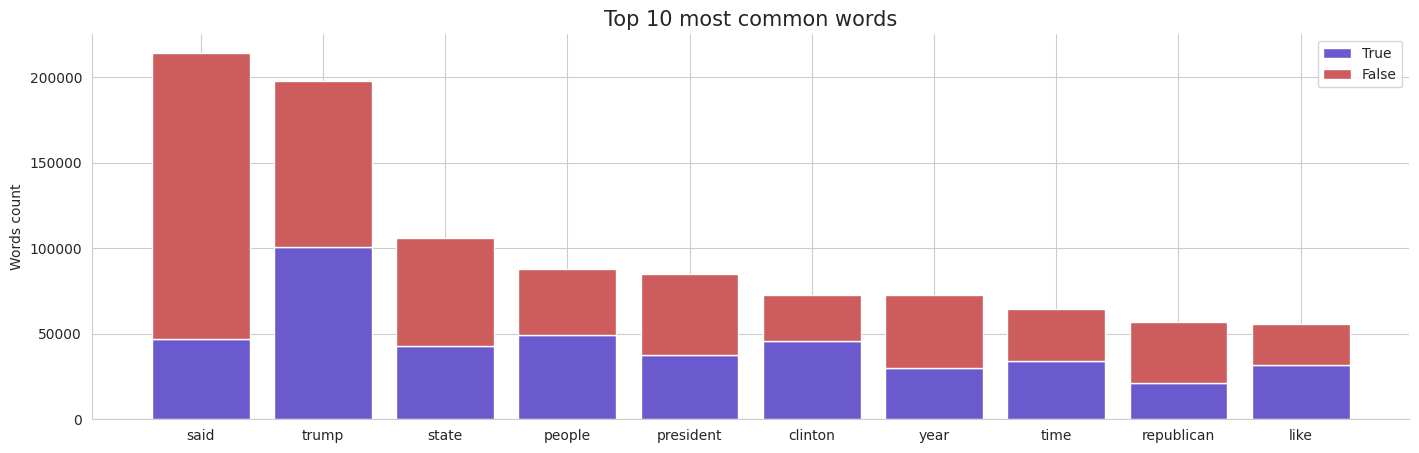

In [ ]:
plt.figure(figsize=(17, 5))
#ax = sns.barplot(x=keys, y=trues)
#sns.set_style('whitegrid')
plt.title(f'Top {n_words} most common words', size=15)
#ax.bar_label(ax.containers[0])
plt.bar(keys, trues, label="True", color="slateblue")
plt.bar(keys, fakes, label="False", bottom=trues, color="indianred")
plt.ylabel("Words count")
plt.legend()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(os.path.join(proj_path, "common.png"), dpi=400)
plt.show()


## 8.3 Word2Vec

Word2vec is a group of related models that are used to produce word embeddings. The underlying assumption of Word2Vec is that two words sharing similar contexts also share an analogous meaning and consequently a vector representation from the model.

In [ ]:
def apply_word2Vec(dataset, vocab_size, vocabulary, embedding_size: int = 200) -> np.ndarray:
    """
      Generates an embedding matrix using Word2Vec.

      Args:
          dataset (list of str): List of text data (each element is a string).
          vocabulary (list of tuples): List of (word, token) pairs representing the vocabulary.
          vocab_size (int): Size of the vocabulary.
          embedding_size (int): Dimensionality of the word embeddings. Default is 200.

      Returns:
          np.ndarray: Embedding matrix of shape (vocab_size, embedding_size).
    """
    w2v = list(map(lambda x: x.split(), dataset))
    w2v_model = Word2Vec(w2v, vector_size=embedding_size)

    embedding_matrix = np.zeros((vocab_size, embedding_size))

    for word, token in vocabulary:
        if word in w2v_model.wv.index_to_key:
            embedding_vector = w2v_model.wv[word]
            embedding_matrix[token] = embedding_vector
    return embedding_matrix

In [ ]:
embedding_matrix_1 = apply_word2Vec(ds1_X, (len(ds1_vocabulary)+1), ds1_vocabulary)

In [ ]:
embedding_matrix_2 = apply_word2Vec(ds2_X, (len(ds2_vocabulary)+1), ds2_vocabulary)

We split the dataset into training, validation, and test sets with a ratio of 70%, 15%, and 15%, respectively.

In [ ]:
ds1_cleanX_train, ds1_cleanX_test, ds1_y_train, ds1_y_test  = train_test_split(ds1_tokenized_column, ds1_y, train_size=0.7, test_size=0.3, stratify=ds1_y)
ds1_cleanX_test, ds1_cleanX_eval, ds1_y_test, ds1_y_eval    = train_test_split(ds1_cleanX_test, ds1_y_test, train_size=0.5, test_size=0.5, stratify=ds1_y_test)

In [ ]:
ds2_cleanX_train, ds2_cleanX_test, ds2_y_train, ds2_y_test  = train_test_split(ds2_tokenized_column, ds2_y, train_size=0.7, test_size=0.3, stratify=ds2_y)
ds2_cleanX_test, ds2_cleanX_eval, ds2_y_test, ds2_y_eval    = train_test_split(ds2_cleanX_test, ds2_y_test, train_size=0.5, test_size=0.5, stratify=ds2_y_test)

## 8.4 Random Over Sampling

*Random Over Sampling* is a technique used to balance the dataset by increasing the representation of the minority class. It randomly duplicates existing samples from the minority class until the class distribution is balanced or reaches a desired ratio.

In [ ]:
ros = RandomOverSampler()
X_train_ros_ds1, y_train_ros_ds1 = ros.fit_resample(np.array(ds1_cleanX_train), np.array(ds1_y_train));
(unique, counts) = np.unique(y_train_ros_ds1, return_counts=True)
np.asarray((unique, counts)).T

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


array([[    0, 15346],
       [    1, 15346]])

In [ ]:
ros = RandomOverSampler()
X_train_ros_ds2, y_train_ros_ds2 = ros.fit_resample(np.array(ds2_cleanX_train), np.array(ds2_y_train));
(unique, counts) = np.unique(y_train_ros_ds2, return_counts=True)
np.asarray((unique, counts)).T

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


array([[    0, 30549],
       [    1, 30549]])

## 8.5 Training and testing

We convert the datasets into PyTorch *TensorDataset* and *DataLoader* objects in order to use them to train and evaluate the LSTM model

In [ ]:
ds1_y_test = np.array(ds1_y_test)
ds1_y_eval = np.array(ds1_y_eval)

ds1_train_data = TensorDataset(torch.tensor(X_train_ros_ds1), torch.tensor(y_train_ros_ds1))
ds1_test_data  = TensorDataset(torch.tensor(ds1_cleanX_test), torch.tensor(ds1_y_test))
ds1_eval_data  = TensorDataset(torch.tensor(ds1_cleanX_eval), torch.tensor(ds1_y_eval))

train_loader_1 = DataLoader(ds1_train_data, shuffle=True, batch_size=32, drop_last=True)
val_loader_1 = DataLoader(ds1_eval_data, shuffle=False, batch_size=32, drop_last=True)
test_loader_1  = DataLoader(ds1_test_data, shuffle=False, batch_size=32, drop_last=True)

In [ ]:
ds2_y_test = np.array(ds2_y_test)
ds2_y_eval = np.array(ds2_y_eval)

ds2_train_data = TensorDataset(torch.tensor(X_train_ros_ds2), torch.tensor(y_train_ros_ds2))
ds2_test_data  = TensorDataset(torch.tensor(ds2_cleanX_test), torch.tensor(ds2_y_test))
ds2_eval_data  = TensorDataset(torch.tensor(ds2_cleanX_eval), torch.tensor(ds2_y_eval))

train_loader_2 = DataLoader(ds2_train_data, shuffle=True, batch_size=32, drop_last=True)
val_loader_2 = DataLoader(ds2_eval_data, shuffle=False, batch_size=32, drop_last=True)
test_loader_2  = DataLoader(ds2_test_data, shuffle=False, batch_size=32, drop_last=True)

The LSTM model is made of:
* Embedding layer
* LSTM layer
* Dropout layer
* Fully connected layer



In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded    = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(lstm_out)  # Get the last time step
        return out

* We use the pre-trained Word2Vec embedding matrix and fine-tune it by updating the embeddings weights during training.
* The loss function used is Binary Cross-Entropy. It is commonly used for binary classification problems that have probabilities between 0 and 1 as outputs which represent the likelihood of belonging to one class or the other.
* The optimizer used is Adam which combines the benefits of adaptive learning rates and momentum to achieve efficient convergence.

In [ ]:
# Initialize model parameters
vocab_size = len(ds1_vocabulary) + 1
embedding_dim = 200
hidden_dim = 64     # Number of LSTM units
output_dim = 1      # Binary classification
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
num_epochs = 15
# Initialize the embedding layer with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix_1))
# Allow the embedding matrix to be fine-tuned to better adapt to our dataset and get higher accuracy
model.embedding.weight.requires_grad = True
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


In [ ]:
def train_lstm(train_loader , val_loader):
    """
      Train the lstm model with the given data loaders

      Args:
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data

      Returns:
        train_losses: List of training losses
        val_losses: List of validation losses
    """

    # Variables for tracking losses
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        all_preds, all_labels = [], []  # To store all predictions and labels for accuracy
        for batch_idx, (text, labels) in enumerate(train_loader):
            text, labels = text.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(text)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Store predictions and labels
            preds = (torch.sigmoid(outputs) > 0.5).long()  # Binary predictions (0 or 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss /= len(train_loader)  # Average loss for the epoch
        train_losses.append(train_loss)
        train_accuracy = accuracy_score(all_labels, all_preds)
        train_accuracies.append(train_accuracy)


        # Validation phase
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch_idx, (text, labels) in enumerate(val_loader):
                text, labels = text.to(device), labels.to(device)
                outputs = model(text)
                loss = criterion(outputs.squeeze(), labels.float())
                val_loss += loss.item()

                preds = (torch.sigmoid(outputs) > 0.5).long()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_accuracy = accuracy_score(all_labels, all_preds)
        val_loss /= len(val_loader)  # Average validation loss for the epoch
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs},"
        f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies = train_lstm(train_loader_1, val_loader_1)

Epoch 1/15,Training Loss: 0.4978, Validation Loss: 0.2568, Training Accuracy: 0.7773, Validation Accuracy: 0.9056
Epoch 2/15,Training Loss: 0.2200, Validation Loss: 0.1848, Training Accuracy: 0.9232, Validation Accuracy: 0.9344
Epoch 3/15,Training Loss: 0.1923, Validation Loss: 0.1697, Training Accuracy: 0.9387, Validation Accuracy: 0.9408
Epoch 4/15,Training Loss: 0.1364, Validation Loss: 0.1519, Training Accuracy: 0.9596, Validation Accuracy: 0.9474
Epoch 5/15,Training Loss: 0.1143, Validation Loss: 0.1476, Training Accuracy: 0.9670, Validation Accuracy: 0.9512
Epoch 6/15,Training Loss: 0.1040, Validation Loss: 0.1421, Training Accuracy: 0.9710, Validation Accuracy: 0.9516
Epoch 7/15,Training Loss: 0.0879, Validation Loss: 0.1378, Training Accuracy: 0.9759, Validation Accuracy: 0.9538
Epoch 8/15,Training Loss: 0.0834, Validation Loss: 0.1348, Training Accuracy: 0.9766, Validation Accuracy: 0.9523
Epoch 9/15,Training Loss: 0.0691, Validation Loss: 0.1374, Training Accuracy: 0.9819, Va

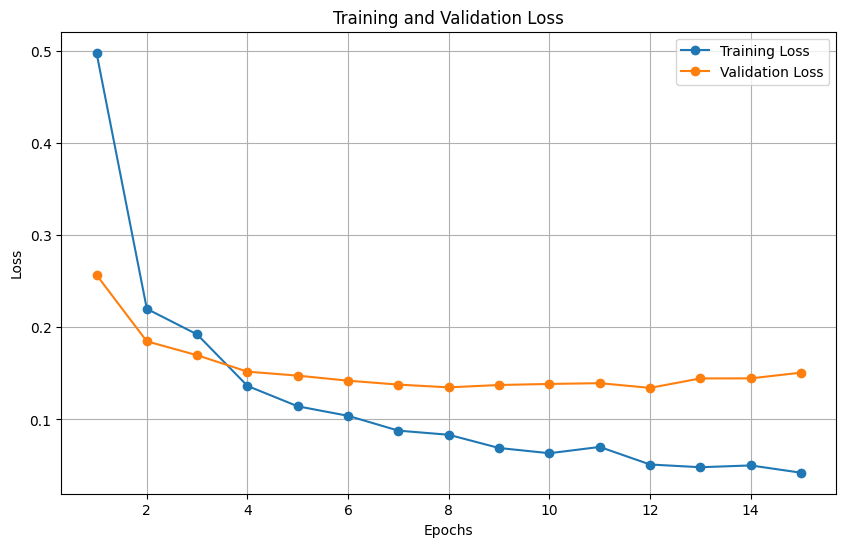

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

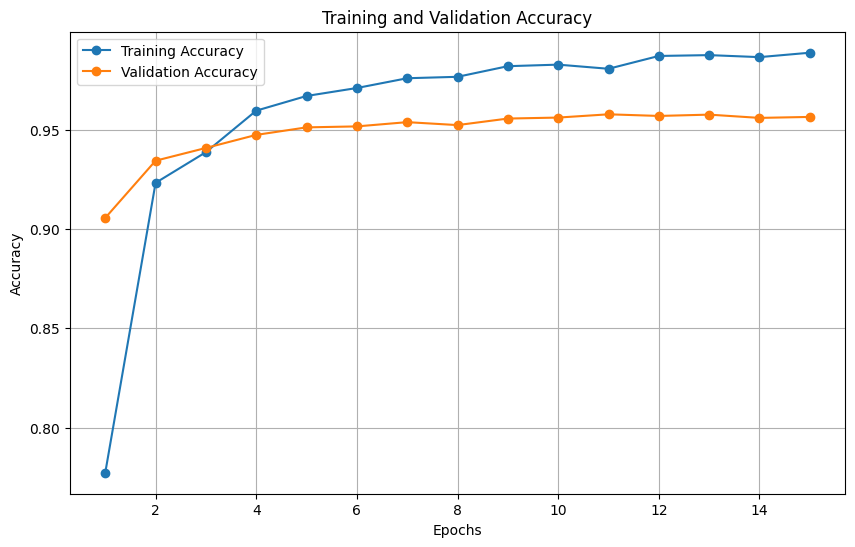

In [ ]:
# Accuracy plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def test_lstm(test_loader) :
    """
      Test the lstm model with the given data loader

      Args:
        test_loader: DataLoader for test data

      Returns:
        all_labels: List of all labels
        all_predictions: List of all predictions
    """
    # Testing the model
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch_idx, (text, labels) in enumerate(test_loader):
            text, labels = text.to(device), labels.to(device)
            outputs = model(text)
            predictions = torch.sigmoid(outputs.squeeze())
            binary_predictions = (predictions > 0.5).long()

            # Store predictions
            all_predictions.append(binary_predictions.to("cpu").numpy())
            all_labels.append(labels.to("cpu").numpy())


    # Flatten the list of predictions
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)
    #print(f"Predictions: {all_predictions}")
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return all_labels, all_predictions


In [ ]:
all_labels, all_predictions = test_lstm(test_loader_1)

Accuracy: 96.15%


In [ ]:
print(classification_report(y_true=all_labels, y_pred=all_predictions))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2795
           1       0.96      0.97      0.96      3285

    accuracy                           0.96      6080
   macro avg       0.96      0.96      0.96      6080
weighted avg       0.96      0.96      0.96      6080



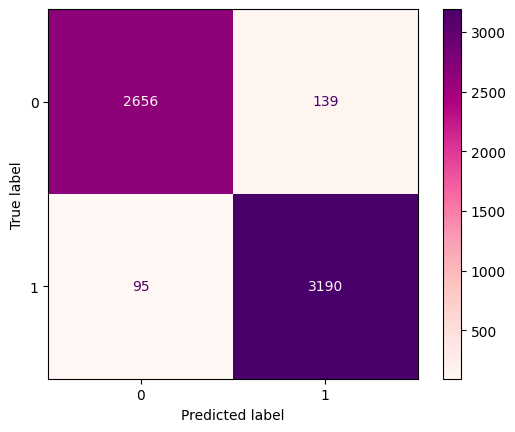

In [ ]:
confusion_mat = confusion_matrix(all_labels, all_predictions)
ConfusionMatrixDisplay(confusion_mat).plot(cmap='RdPu')


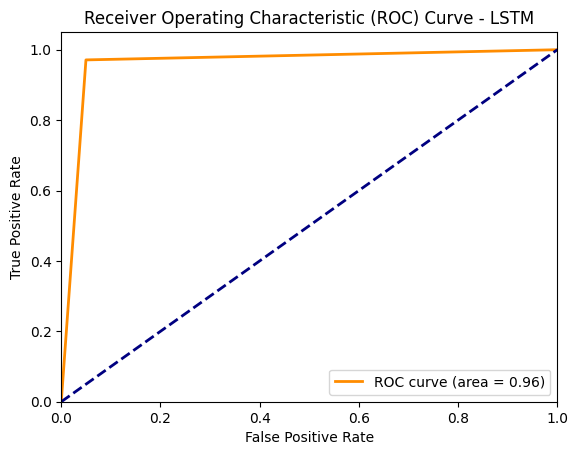

In [ ]:
roc_auroc(all_labels, all_predictions, 'LSTM')

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded    = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(lstm_out)  # Get the last time step
        return out

In [ ]:
# Initialize model parameters
vocab_size = len(ds2_vocabulary) + 1
embedding_dim = 200
hidden_dim = 64     # Number of LSTM units
output_dim = 1      # Binary classification
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
num_epochs = 20

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies = train_lstm(train_loader_2, val_loader_2)

Epoch 1/20,Training Loss: 0.4470, Validation Loss: 0.3412, Training Accuracy: 0.7930, Validation Accuracy: 0.8640
Epoch 2/20,Training Loss: 0.3058, Validation Loss: 0.3355, Training Accuracy: 0.8824, Validation Accuracy: 0.8634
Epoch 3/20,Training Loss: 0.2540, Validation Loss: 0.2388, Training Accuracy: 0.9066, Validation Accuracy: 0.9091
Epoch 4/20,Training Loss: 0.2147, Validation Loss: 0.2150, Training Accuracy: 0.9222, Validation Accuracy: 0.9209
Epoch 5/20,Training Loss: 0.1935, Validation Loss: 0.1972, Training Accuracy: 0.9293, Validation Accuracy: 0.9274
Epoch 6/20,Training Loss: 0.1707, Validation Loss: 0.1939, Training Accuracy: 0.9394, Validation Accuracy: 0.9305
Epoch 7/20,Training Loss: 0.1540, Validation Loss: 0.1830, Training Accuracy: 0.9450, Validation Accuracy: 0.9339
Epoch 8/20,Training Loss: 0.1947, Validation Loss: 0.2076, Training Accuracy: 0.9295, Validation Accuracy: 0.9267
Epoch 9/20,Training Loss: 0.1374, Validation Loss: 0.2100, Training Accuracy: 0.9525, Va

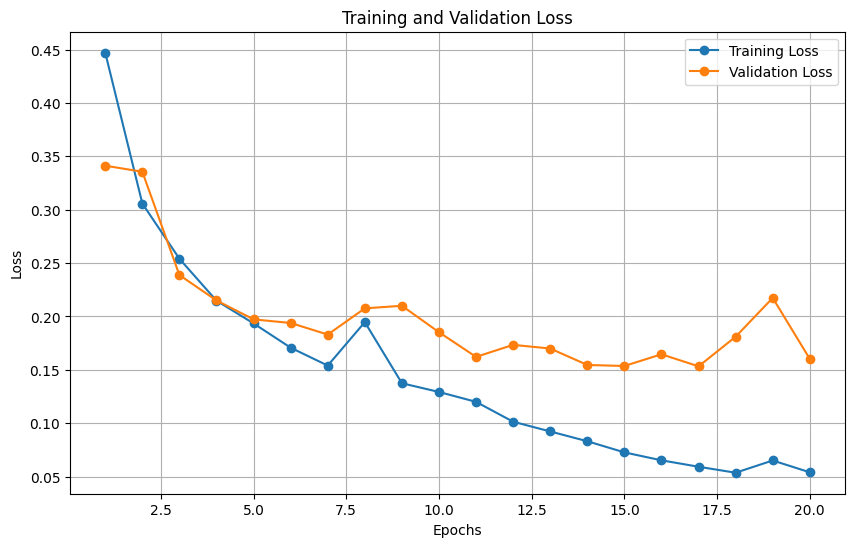

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

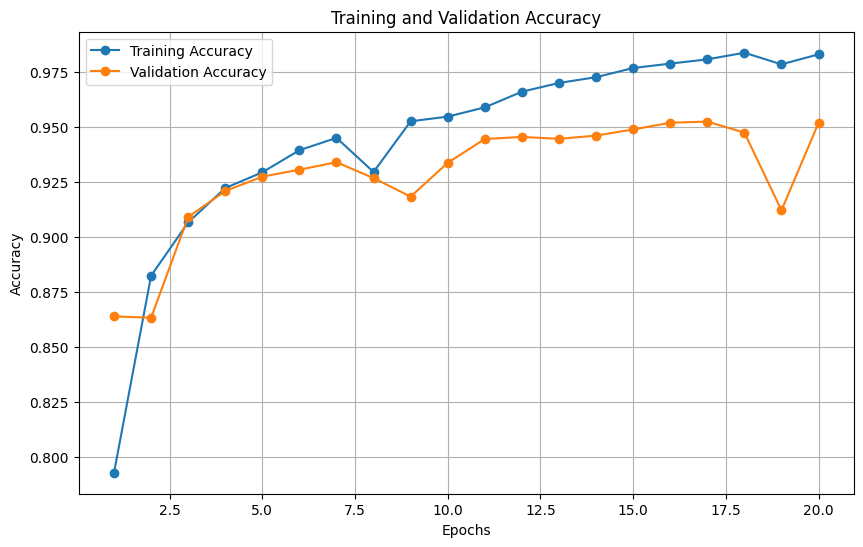

In [ ]:
# Accuracy plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
all_labels, all_predictions = test_lstm(test_loader_2)

Accuracy: 95.64%


In [ ]:
print(classification_report(y_true=all_labels, y_pred=all_predictions))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      6537
           1       0.96      0.94      0.95      5239

    accuracy                           0.96     11776
   macro avg       0.96      0.96      0.96     11776
weighted avg       0.96      0.96      0.96     11776



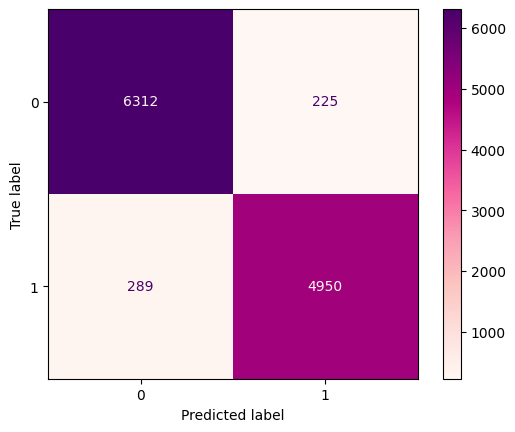

In [ ]:
confusion_mat = confusion_matrix(all_labels, all_predictions)
ConfusionMatrixDisplay(confusion_mat).plot(cmap='RdPu')

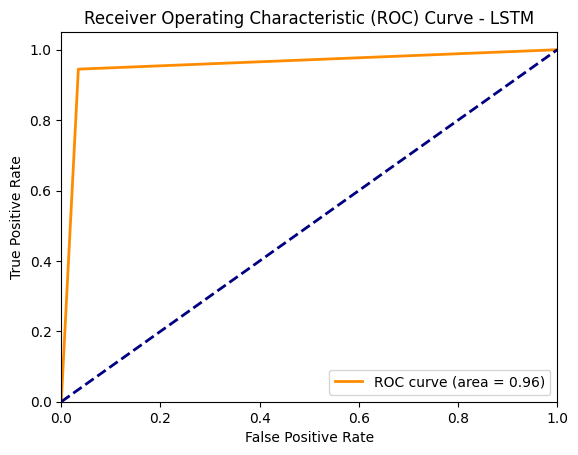

In [ ]:
roc_auroc(all_labels, all_predictions, 'LSTM')